In this notebook, we are working with memes900k dataset. Please make sure you have downloaded it if you want to work with this notebook: https://drive.google.com/file/d/1j6YG3skamxA1-mdogC1kRjugFuOkHt_A/edit.

#### HuggingFace inference, BLIP2 image captioning model

In [3]:
import requests
import os
from tqdm import tqdm
import json

In [4]:
hf_token = "hf_YOUR_TOKEN"
# Your home directry:
home_dir = os.path.expanduser("~")
home_dir = os.path.join(home_dir, 'Downloads', "meme_caption_generator")

In [26]:
API_URL = "https://api-inference.huggingface.co/models/Salesforce/blip-image-captioning-base"
headers = {"Authorization": f"Bearer {hf_token}"}

def query(filename):
    with open(filename, "rb") as f:
        data = f.read()
    response = requests.post(API_URL, headers=headers, data=data)
    return response.json()

In [39]:
output = query(f"memes900k/images/you-were-the-chosen-one.jpg")

In [47]:
output[0]['generated_text']

'a man with a beard and a beard in a scene from the movie star wars'

Load files

In [42]:
def list_files(directory):
    try:
        files = os.listdir(directory)
        file_names = [f for f in files if os.path.isfile(os.path.join(directory, f))]
        
        return file_names
    except FileNotFoundError:
        print("The specified directory does not exist.")
        return []
    except PermissionError:
        print("Permission denied to access the directory.")
        return []

In [43]:
directory_path = 'memes900k/images'
files = list_files(directory_path)

In [46]:
os.path.join(directory_path, files[0])

'memes900k/images/kd-you-the-real-mvp-f.jpg'

In [55]:
img_to_description = dict()
for file in tqdm(files):
    img = os.path.join(directory_path, file)
    output = query(img)[0]['generated_text']
    img_to_description[file] = output

  0%|          | 0/2 [00:00<?, ?it/s]

{'error': 'Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate'}


KeyError: 0

In [59]:
# with open('img_to_description.json', 'w', encoding='utf-8') as file:
#     json.dump(img_to_description, file) 

Read captions of memes

In test there should be images not seen in training.

### Preparing data for training

Extract memes' captions. 

In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, default_data_collator, get_linear_schedule_with_warmup
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, PrefixTuningConfig, TaskType
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from datasets import Dataset
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [76]:
with open("memes900k/captions.txt", "r", encoding='utf-8') as file:
    captions = file.readlines()

In [82]:
with open("memes900k/templates.txt", "r", encoding='utf-8') as file:
    templates = file.readlines()

Need to preprocess the captions so that the meme name is the same as the name of the corresponding image meme

In [94]:
img_to_description['y-u-no.jpg']

'y y y y y y y y y y y y y y y y y y y'

In [108]:
meme_properties = dict()
for i in range(len(templates)):
    line = templates[i].split('\t')
    name = line[0]
    nickname = line[1].strip("/").lower()
    file_path = nickname+'.jpg'
    meme_properties[name] = {}
    meme_properties[name]['nickname'] = nickname
    meme_properties[name]['file_path'] = file_path
    meme_properties[name]['description'] = img_to_description[file_path]
    meme_properties[name]['captions'] = []

In [111]:
for i in range(len(captions)):
    line = captions[i].split('\t')
    name = line[0]
    caption = line[-1].strip("\n")
    meme_properties[name]['captions'].append(caption)

In [117]:
# with open('meme_properties.json', 'w', encoding='utf-8') as file:
#     json.dump(meme_properties, file)

Now let's create a .csv file with descriptions of memes as input and caption as output

Had to describe one file with another model since its generated description was "y y y y y y y y y y y y y y y y y y y"

In [120]:
df = pd.DataFrame(columns=['descriptions', 'captions'])

In [121]:
i = 0
for meme in meme_properties:
    descr = meme_properties[meme]['description']
    for caption in meme_properties[meme]['captions']:
        df.loc[i] = [descr, caption]
        i+=1

KeyboardInterrupt: 

In [129]:
df

,descriptions,captions
0,"a simple, stylized drawing of a face with a ve...",commercial <sep> y u no same volume as show!?
1,"a simple, stylized drawing of a face with a ve...",Victoria <sep> y u no tell us your secret?!
2,"a simple, stylized drawing of a face with a ve...",KONY <sep> Y u no take justin bieber
3,"a simple, stylized drawing of a face with a ve...",TED <sep> y u no tell us how you met their mother
4,"a simple, stylized drawing of a face with a ve...",Google <sep> Y U NO LET ME FINISH TYPING?
...,...,...
696091,a cartoon of two men standing in front of a bl...,Uh huh huh <sep> you said 69
696092,a cartoon of two men standing in front of a bl...,"huh huh huh <sep> she said ""hard"""
696093,a cartoon of two men standing in front of a bl...,I got wood <sep> Yeah
696094,a cartoon of two men standing in front of a bl...,"HU HU HU HU <sep> She said ""balls."""


In [131]:
i = 696096
meme = "Beavis and butthead"
descr = meme_properties[meme]['description']
for j in range(96, len(meme_properties[meme]['captions'])):
    caption = meme_properties[meme]['captions'][j]
    df.loc[i] = [descr, caption]
    i+=1

In [136]:
for m in tqdm(range(233, len(list(meme_properties.keys())))):
    meme = list(meme_properties.keys())[m]
    descr = meme_properties[meme]['description']
    for caption in tqdm(meme_properties[meme]['captions']):
        df.loc[i] = [descr, caption]
        i+=1

100%|██████████| 67/67 [1:01:28<00:00, 55.05s/it]


In [138]:
# df.to_csv("dataset_descr_captions.csv", index=False)

In [141]:
df[df['descriptions']]

,descriptions,captions
0,"a simple, stylized drawing of a face with a ve...",commercial <sep> y u no same volume as show!?
1,"a simple, stylized drawing of a face with a ve...",Victoria <sep> y u no tell us your secret?!
2,"a simple, stylized drawing of a face with a ve...",KONY <sep> Y u no take justin bieber
3,"a simple, stylized drawing of a face with a ve...",TED <sep> y u no tell us how you met their mother
4,"a simple, stylized drawing of a face with a ve...",Google <sep> Y U NO LET ME FINISH TYPING?
...,...,...
899995,the dark knight rises,When reading time commences <sep> you have my ...
899996,the dark knight rises,only when my mind is in ashes <sep> do you hav...
899997,the dark knight rises,when facebook has emotions <sep> you have my p...
899998,the dark knight rises,WHEN YOU HAVE FIXED YOUR GRAMMAR <sep> then yo...


Some descriptions generated by BLIP ended up messy. E.g.
fusosososososososososososososososososo',

 'gan gan gan gan gan gan gan gan gan gan gan gan gan gan gan gan gan gan gan',

 'gro gro gro gro gro gro gro gro gro gr'
 
 Define a function to only consider descriptions that don't repeat.

In [157]:
# create a function
def is_not_garbage_description(d_string):
    d_string = d_string.split()
    try:
        if d_string[-2] == d_string[-3] == d_string[-4]:
            return False
    except:
        return True
    else:
        return True

In [158]:
df_filtered = df[df['descriptions'].apply(is_not_garbage_description)]

In [159]:
df_filtered

,descriptions,captions
0,"a simple, stylized drawing of a face with a ve...",commercial <sep> y u no same volume as show!?
1,"a simple, stylized drawing of a face with a ve...",Victoria <sep> y u no tell us your secret?!
2,"a simple, stylized drawing of a face with a ve...",KONY <sep> Y u no take justin bieber
3,"a simple, stylized drawing of a face with a ve...",TED <sep> y u no tell us how you met their mother
4,"a simple, stylized drawing of a face with a ve...",Google <sep> Y U NO LET ME FINISH TYPING?
...,...,...
899995,the dark knight rises,When reading time commences <sep> you have my ...
899996,the dark knight rises,only when my mind is in ashes <sep> do you hav...
899997,the dark knight rises,when facebook has emotions <sep> you have my p...
899998,the dark knight rises,WHEN YOU HAVE FIXED YOUR GRAMMAR <sep> then yo...


In [161]:
# df_filtered.to_csv("df_filtered_descr_captions.csv", index=False)

In [5]:
df_filtered = pd.read_csv("df_filtered_descr_captions.csv") 

We have 300 unique images with descriptions. Each has 3000 descriptions. Is it maybe too much?
Maybe good if we want to generate with a specific template.

In [7]:
df_grouped = df_filtered.groupby('descriptions')['captions'].apply(lambda x: x.head(10)).reset_index()


In [8]:
df_grouped[:20]

,descriptions,level_1,captions
0,a baby laughing,819000,i've got a surpise in my diaper <sep> and it's...
1,a baby laughing,819001,I WANT TO MAKE PLANS <sep> FOR OUR ANNIVERSARY
2,a baby laughing,819002,she can't see <sep> everybody reads this shiet!
3,a baby laughing,819003,"I did it <sep> it's ""Legal"" !!!"
4,a baby laughing,819004,I will burn your precious <sep> village
5,a baby laughing,819005,i'll tell that bitch i chant <sep> bitches lov...
6,a baby laughing,819006,martial law? <sep> sounds like kill a cop to me
7,a baby laughing,819007,you've not seen star wars yet <sep> let me tel...
8,a baby laughing,819008,GUESS WHAT I DID <sep> HINT IT'S IN MY NAPPY
9,a baby laughing,819009,i still have a hape <sep> of last years turf


In [9]:
df_shuffled = df_grouped.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled = df_shuffled.drop(columns=['level_1'])

In [11]:
model_name_or_path = "google/flan-t5-xxl"
tokenizer_name_or_path = "google/flan-t5-xxl"

text_column = "description"
label_column = "caption"
# max_length = 128
lr = 1e-2
num_epochs = 3
batch_size = 8

In [12]:
# Create Transformers dataset
data = {"caption": [word for word in df_shuffled['captions']], "description":[descr for descr in df_shuffled['descriptions']]}
dataset = Dataset.from_dict(data)
dataset_split = dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)
dataset_split['train'][0]

{'caption': 'Cloud storage <sep> now supported',
 'description': 'a man with glasses and a beard smiles at the camera'}

In [13]:
captions = dataset_split['train']['caption']
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
caption_max_length = max([len(tokenizer(caption)["input_ids"]) for caption in captions])
print(caption_max_length)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

47


/Users/nursulusagimbayeva/Downloads/BMW_intern_GenAI_coding_task/.bmw_env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    prefix = "Description: "
    suffix = ". Caption: "
    inputs = [prefix + input_text + suffix for input_text in inputs]

    model_inputs = tokenizer(inputs, max_length=caption_max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, max_length=caption_max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

/Users/nursulusagimbayeva/Downloads/BMW_intern_GenAI_coding_task/.bmw_env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
processed_datasets = dataset_split.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset_split["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/1960 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/490 [00:00<?, ? examples/s]

In [23]:
processed_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1960
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 490
    })
})

In [24]:
train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["test"]

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

In [25]:
for i in range(10):
    print(tokenizer.decode(train_dataset['input_ids'][i], skip_special_tokens=True))

Description: a man with glasses and a beard smiles at the camera. Caption: 
Description: a black background with a white and red flower. Caption: 
Description: a picture of a young boy with a smile. Caption: 
Description: the cover of the album,'the man who knew the world '. Caption: 
Description: a black and white photo of a man in a suit. Caption: 
Description: a black background with a white and red flower. Caption: 
Description: a cartoon character with a red hair and glasses. Caption: 
Description: a poster of a man with a cigarette. Caption: 
Description: a man in a suit and tie standing next to the ocean. Caption: 
Description: a man is holding a remote control device. Caption: 


### Training

In [26]:
peft_config = PrefixTuningConfig(task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, num_virtual_tokens=20)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/9.60G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/6.06G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [27]:
import wandb

In [28]:
# Initialize W&B
wandb.init(project="caption_generation_3_epochs_xxl", entity="nurs-sagimbayeva")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nurs-sagimbayeva. Use `wandb login --relogin` to force relogin


In [29]:
model.print_trainable_parameters()
"trainable params: 983040 || all params: 738651136 || trainable%: 0.13308583065659835"

trainable params: 3,932,160 || all params: 11,139,264,512 || trainable%: 0.0353


'trainable params: 983040 || all params: 738651136 || trainable%: 0.13308583065659835'

In [30]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [31]:
model = model.to(device)

for epoch in range(num_epochs):
    print(f"-----Epoch {epoch} has started-----")
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        wandb.log({"train_loss": loss.item(), "epoch": epoch})

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    
        # Log evaluation metrics
    wandb.log({
        "eval_loss": eval_epoch_loss.item(),
        "eval_ppl": eval_ppl.item(),
        "train_loss": train_epoch_loss.item(),
        "train_ppl": train_ppl.item(),
        "epoch": epoch
    })
    
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")

KeyboardInterrupt: 

In [242]:
for i in range(len(dataset_split['test']['description'])):
    print(dataset_split['test']['description'][i])
    print("Actual caption:", dataset_split['test']['caption'][i])
    print("prediction:", eval_preds[i])

a man sitting at a table with a cup
Actual caption: she returned a high five <sep> So I guess you could say things are getting pretty serious
prediction: A is to cup scoresep>,' I can say  like  better good                      A
a baby sitting at a table with a beer
Actual caption: I met a cute chick at the sandbox <sep> i was like"You and i should go chill at my crib"
prediction: A' a baby babyk  the barzex castlesep>  love 'mei are go to the house          
a man with glasses and a green background
Actual caption: What if i told you <sep> There was more to an election than same sex marriage and abortion
prediction: A a wei can you isep>  is  to do hour you ex                   
a bear with a capt that says, i'm'm'm'm'm
Actual caption: Kidnapping? <sep> I prefer the term "SURPRISE Adoption"
prediction:  ap sep>'to  sePRISE"dict"                    A A A
a man with a mustache and mustaches on his face
Actual caption: watch out guys <sep> ill get on my 138 main
prediction: A  forsep>  

In [249]:
pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [250]:
from huggingface_hub import notebook_login

notebook_login()

In [258]:
peft_model_id = "meme_caption_generator_FLAN-T5-large_prefix_tuned"
model.push_to_hub(peft_model_id, use_auth_token=True, create_pr=1)

/Users/nursulusagimbayeva/Downloads/BMW_intern_GenAI_coding_task/.bmw_env/lib/python3.11/site-packages/transformers/utils/hub.py:875: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


LocalTokenNotFoundError: Token is required (`token=True`), but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens.

In [259]:
import os

In [268]:
os.environ['HUGGINGFACE_TOKEN'] = "hf_YOUR_TOKEN"

In [269]:
from huggingface_hub import login

# Replace 'your_token_here' with your actual token
login(token="hf_YOUR_TOKEN")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/nursulusagimbayeva/.cache/huggingface/token
Login successful


In [271]:
peft_model_id = "meme_caption_generator_FLAN-T5-large_prefix_tuned"
model.push_to_hub(peft_model_id, use_auth_token=True, create_pr=1)

adapter_model.safetensors: 100%|██████████| 3.93M/3.93M [00:09<00:00, 430kB/s]


CommitInfo(commit_url='https://huggingface.co/NursNurs/meme_caption_generator_FLAN-T5-large_prefix_tuned/commit/6b40fe636ce290718f8844f9ad3061ed5c6965c9', commit_message='Upload model', commit_description='', oid='6b40fe636ce290718f8844f9ad3061ed5c6965c9', pr_url='https://huggingface.co/NursNurs/meme_caption_generator_FLAN-T5-large_prefix_tuned/discussions/1', pr_revision='refs/pr/1', pr_num=1)

In [247]:
# Define input text
input_text = "Translate English to French: How are you?"

# Tokenize the input
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Generate output
outputs = model.generate(input_ids)

# Decode and print the generated text
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

TypeError: PeftModelForSeq2SeqLM.generate() takes 1 positional argument but 2 were given

In [20]:
def process_image(image_path: str) -> str:
    CONTEXT = "A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions.\n"

    with open(image_path, 'rb') as f:
        img_str = base64.b64encode(f.read()).decode('utf-8')
        prompt = CONTEXT + f'### Human: Describe the image: \n<img src="data:image/jpeg;base64,{img_str}">### Assistant: '### Human: What is unusual about this image: \n<img src="data:image/jpeg;base64,{img_str}">### Assistant: '

        data = {
            "mode": "instruct", # chat, instruct
            "character": "Example",
#           "instruction_template": "LLaVA-v1",
            "messages": [{"role": "system", "content": prompt}]
        }
        

        response = requests.post('http://127.0.0.1:5000/v1/chat/completions', json=data)
        print(response)

        if response.status_code != 200:
            print(response.text)
            print(f"Request failed with status {response.status_code}. Response: {response.json()}")
            return None
        else:
            print(response.text)
            return response.json()['choices'][0]['message']['content']

In [2]:
import json

In [3]:
with open("memes_900k_files/meme_properties.json", 'r') as file:
    meme_properties = json.load(file)

In [4]:
meme_properties.keys()


dict_keys(['Y U No', 'Bad Luck Brian', 'Willy Wonka', 'The Most Interesting Man In The World', 'Futurama Fry', 'Success Kid', 'One Does Not Simply', 'First World Problems', 'Philosoraptor', 'Grumpy Cat ', 'Winter is Coming', 'Forever Alone', 'Good Guy Greg', 'Scumbag Steve', 'What If I Told You', 'Kermit The Frog Drinking Tea', 'Conspiracy Keanu', 'Yo Dawg', 'All the things', 'Insanity Wolf', 'Joseph Ducreux', 'Trollface', 'Pedobear', 'Skeptical 3rd World Kid', 'Annoying Facebook Girl', 'Disaster Girl', 'Socially Awkward Penguin', 'Prepare yourself', 'Slowpoke', 'Dr Evil meme', 'Advice Yoda Gives', 'joker mind loss', 'Stoner Stanley', 'Foul Bachelor Frog', 'pleaseguy ', 'batman slap robin', 'High Expectations Asian Father', "Koala can't believe it", 'MR bean', 'Chuck Norris ', 'Overly Attached Girlfriend', 'Butthurt Dweller', 'Desk Flip Rage Guy', 'Whyyy???', 'Business Cat', 'drunk baby 1', 'Correction Guy', "So You're Telling me", "south park aand it's gone", 'Skeptical African Child'

In [5]:
import pandas as pd
from collections import Counter

In [6]:
df = pd.read_csv("memes_900k_files/sentiments_captions.csv")

In [7]:
df_angry = df[df['sentiments']=='angry']

In [27]:
brace_yourselves = df_angry[df_angry['descriptions'] == 'a man in a fur coat holding a microphone']

In [8]:
y_u_no =  df_angry[df_angry['descriptions'] == 'a simple, stylized drawing of a face with a very exaggerated expression of anger or frustration']

In [9]:
y_u_no = list(y_u_no['captions'])


In [10]:
len(y_u_no)

3000

In [12]:
y_u_so =  df_angry[df_angry['descriptions'] == 'a rage rage rage rage rage rage rage rage rage rage rage rage rage rage rage rage rage rage']

In [13]:
y_u_so = list(y_u_so['captions'])

In [14]:
len(y_u_so)

3000

In [15]:
y_u_memes = y_u_no + y_u_so

In [16]:
len(y_u_memes)

6000

In [18]:
with open("y_u_memes.json", 'w') as file:
    json.dump(y_u_memes, file)

In [7]:
brace_yourselves = list(brace_yourselves['captions'])

In [8]:
len(brace_yourselves)

6000

In [19]:
df_happy = df[df['sentiments']=='happy']

In [33]:
list(df_happy['captions'])[15300:15350]

["just wanted to say... <sep> happy mother's day!!!",
 'You mad bro? <sep> <emp>',
 'complain about league of legends burst <sep> plays annie',
 'hmmmm <sep> indeed she is preety',
 'Are you sure that england can win tonight? <sep> balotelli will beat you england !!',
 'fffrrrrtttt <sep> excuse me',
 'sex pistlos <sep> if you know what i mean',
 'NO <sep> JUST NO',
 'may i have a peek <sep> at your tits?',
 'Well she was just seventeen <sep> if you know what I mean',
 'CAN YOU BLOW MY <sep> WHISTLE BABY',
 'Mr. bean? <sep> Nah, Mr. Badi.',
 '<emp> <sep> whats so funny?',
 'E ka patellxhanin ti mabi? <sep> if u know what i mean',
 '<emp> <sep> smell my fart yet?',
 'sorry <sep> i just got back from vaktovia',
 'THat face <sep> mli kat 7ze9 west jma3a',
 'DID I SEE <sep> WHAT YOU THERE DID?',
 "You say you're leet hacker? <sep> i think not.",
 'you are my kinky temptress of love <sep> sexy little angel you',
 'YOU HAVE TWO CHOICES, <sep> consensual sex, or rape?',
 'i just let the little

In [34]:
if_you_know = df_happy[df_happy['captions'] == 'Farted In Class <sep> No One Heard']

In [40]:
descr = if_you_know['descriptions'].iloc[0]

In [43]:
for el in meme_properties:
    if meme_properties[el]['description'] == descr:
        print(el)

MR bean


In [41]:
if_you_know = df_happy[df_happy['descriptions'] == descr]

In [42]:
if_you_know

,descriptions,captions,sentiments
114000,a man in a suit and tie standing next to the o...,That face your friend gives you <sep> When you...,happy
114001,a man in a suit and tie standing next to the o...,getting up is the second hardest thing in the ...,happy
114002,a man in a suit and tie standing next to the o...,do you live on a chicken farm? <sep> Cause you...,happy
114003,a man in a suit and tie standing next to the o...,Teacher says piCk a pArtner <sep> Look at Your...,happy
114004,a man in a suit and tie standing next to the o...,you like krabby patties <sep> don't you squidw...,happy
...,...,...,...
116995,a man in a suit and tie standing next to the o...,hmmm <sep> its friday,happy
116996,a man in a suit and tie standing next to the o...,that face your friend gives you <sep> when a h...,happy
116997,a man in a suit and tie standing next to the o...,"Ragazzi, domani vi faccio il culo <sep> cit.pr...",happy
116998,a man in a suit and tie standing next to the o...,i dont need hair WAX <sep> if you know what i ...,happy


In [48]:
sneaky_guy = df[df['descriptions']=='a man with a black shirt and a black tie']

In [44]:
if_you_know = list(if_you_know['captions'])

In [45]:
with open("mr_bean.json", 'w') as file:
    json.dump(if_you_know, file)

In [54]:
list(sneaky_guy['captions'])[80:100]

['oh goody henry has two <sep> spiderman inflatables',
 'the look you give your buddy when your white tac <sep> does 230 damage to a skull trooper',
 'when you gave her all the attention yesterday <sep> and you know she gonna give it to you today',
 'WHEN I SEE YOU PARAS, <sep> AND YOU SLEEPING ..',
 '*creepy* <sep> im looking at yOU...',
 'LADIES AND GENTLEMEN... <sep> MISS KD LANG',
 'How to tell <sep> Who farted in class',
 'CREO QUE SE SIGUE ENOJANDO <sep> <emp>',
 'Parents leaving out of the door for a week cruise <sep> knows where the seagrams 7 is',
 'UM <sep> I MIGHT OF HAD SEX WITH HIM',
 '<emp> <sep> SGUELLA LIBRE',
 'bruce dean professional recreationalist <sep> loves my golden showers.',
 'WHEN UR FRIENDS SAW <sep> YOU SWEAR WHEN YOU WERE 10',
 "pshhh <sep> that donkeys' dick is huge",
 "I DIDN'T FUCK <sep> HARRY'S GIRLFRIEND",
 'Mmmh... <sep> Cinnamon Buns',
 "THE FACE YOU MAKE <sep> WHEN YOU'RE FIRST CRUSH LIKES YOU BACK",
 "I'VE PARKED NEXT TO A <sep> SKODA LABIA...",
 "

In [55]:
sneaky_guy = list(sneaky_guy['captions'])

In [57]:
with open("sneaky_guy.json", 'w') as file:
    json.dump(sneaky_guy, file)

In [18]:
import json
import re
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForMaskedLM
import matplotlib.pyplot as plt
import torch
from langdetect import detect
import numpy as np

In [10]:
# Load pre-trained BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

/Users/nursulusagimbayeva/Downloads/BMW_intern_GenAI_coding_task/.bmw_env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpo

In [12]:
def preprocess_text(text):
    # detect language. If not english, remove
    lan = detect(text)
    if lan != 'en':
        return None
    # lower case
    text = text.lower()
    return text

In [13]:
brace_yourselves_processed = list(map(preprocess_text, brace_yourselves))

In [14]:
# Function to generate BERT embeddings
def get_bert_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    embeddings = outputs['hidden_states'][-1].mean(dim=1)
    return embeddings


# Plotting using Matplotlib
def plot_clusters(plot_df, title):
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(plot_df['x'], plot_df['y'], c=plot_df['Cluster'], cmap='viridis')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Cluster')
    for i, doc in enumerate(plot_df['Document']):
        plt.annotate(doc, (plot_df['x'][i], plot_df['y'][i]))
    plt.show()

In [15]:
brace_yourselves_processed = [el for el in brace_yourselves_processed if el != None]

In [16]:
len(brace_yourselves_processed)

5471

In [17]:
embeddings_brace_yourselves = get_bert_embeddings(brace_yourselves_processed, tokenizer, model)

In [19]:
np.savez('embeddings_brace_yourselves.npz')


In [21]:
documents = brace_yourselves_processed
embeddings = embeddings_brace_yourselves

In [22]:
from sklearn.cluster import KMeans  # For KMeans clustering
from sklearn.manifold import TSNE   # For t-SNE dimensionality reduction
from sklearn.decomposition import PCA

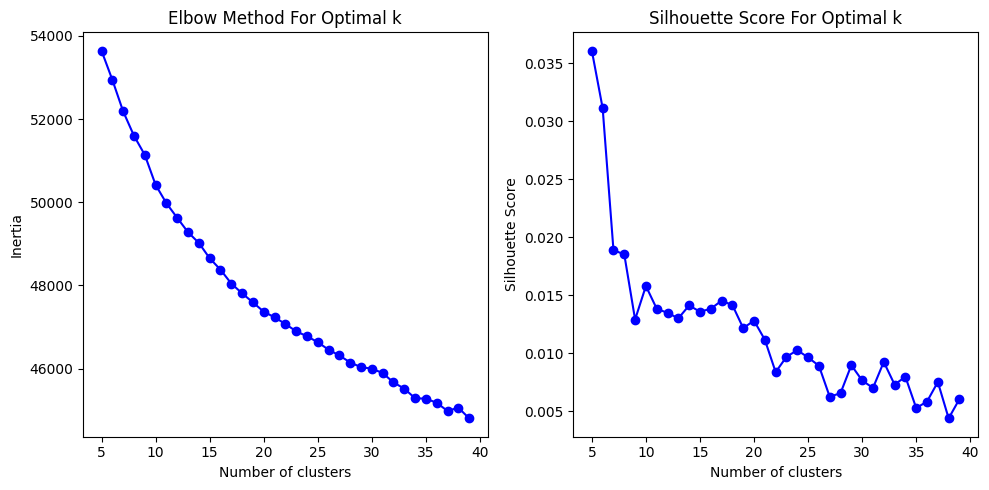

ValueError: perplexity must be less than n_samples

In [25]:
# Elbow Method to determine optimal number of clusters
inertia = []
silhouette_scores = []
K = range(5, 40)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(embeddings)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(embeddings, km.labels_))

# Plotting the Elbow Method results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

# Plotting the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

# Choose the optimal number of clusters based on the plots
optimal_clusters = 2  # Assume this based on the elbow method and silhouette score

# Clustering using KMeans with optimal number of clusters
km = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = km.fit_predict(embeddings)

# Access cluster centers
cluster_centers = km.cluster_centers_

# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
reduced_embeddings_pca = pca.fit_transform(embeddings)
reduced_cluster_centers_pca = pca.transform(cluster_centers)

# Dimensionality Reduction using t-SNE (with perplexity less than number of samples)
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
reduced_embeddings_tsne = tsne.fit_transform(embeddings)
reduced_cluster_centers_tsne = tsne.fit_transform(cluster_centers)

# Create a DataFrame for plotting
plot_df_pca = pd.DataFrame({
    'x': reduced_embeddings_pca[:, 0],
    'y': reduced_embeddings_pca[:, 1],
    'Cluster': clusters,
    'Document': documents
})

plot_df_tsne = pd.DataFrame({
    'x': reduced_embeddings_tsne[:, 0],
    'y': reduced_embeddings_tsne[:, 1],
    'Cluster': clusters,
    'Document': documents
})

# Function to plot clusters with centers
def plot_clusters_with_centers(plot_df, centers, title):
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(plot_df['x'], plot_df['y'], c=plot_df['Cluster'], cmap='viridis', label='Documents')
    plt.scatter(centers[:, 0], centers[:, 1], s=200, c='red', marker='X', label='Cluster Centers')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Cluster')
    for i, doc in enumerate(plot_df['Document']):
        plt.annotate(doc, (plot_df['x'][i], plot_df['y'][i]))
    plt.legend()
    plt.show()

# Plot PCA clusters with centers
plot_clusters_with_centers(plot_df_pca, reduced_cluster_centers_pca, "PCA Clustering of Documents with Centers")

# Plot t-SNE clusters with centers
plot_clusters_with_centers(plot_df_tsne, reduced_cluster_centers_tsne, "t-SNE Clustering of Documents with Centers")

In [26]:
# Clustering using KMeans
num_clusters = 17
km = KMeans(n_clusters=num_clusters, random_state=42)
clusters = km.fit_predict(embeddings)

In [27]:
cluster_centers = km.cluster_centers_


In [29]:
docs_df = pd.DataFrame({
    'Document': documents,
    'Cluster': clusters
})

In [32]:
with open("brace_yourselves.json", 'w') as file:
    json.dump(brace_yourselves_processed, file)

In [ ]:
doc

In [22]:
list(df_angry['captions'])[100:120]

['america <sep> y u no vote for ron paul?!',
 '1% germ <sep> y u no die?',
 'hey creator of this template... <sep> y u no fill in the space between my arms blue',
 'THE REAL SLIM SHADY <sep> Y U NO STAND UP?',
 'bing <sep> y u no do barrel roll?!',
 'Pedobear <sep> Y u no take Justin Bieber with you?',
 'facebook <sep> y u no support gifs?',
 'memegenerator <sep> y u always down',
 'people making arrow-knee joke: <sep> y u no funny?',
 'FRODO <sep> y u no just fly on eagles into mordor?',
 'angelina jolie <sep> y u no take konys CHILDREN',
 'george <sep> y u so curious',
 'SUPPORT GUY <sep> Y U NO GIVE ME AMMO',
 'BACON <sep> y u no stay same size when I cook you?',
 'Gym teachers <sep> Y U No healthy!!!',
 'people on memegenerator <sep> y u no have original ideas?',
 'Brain <sep> Y u no think of something good to put here?',
 'chihuahua <sep> y u no realize i can kick u',
 'voice <sep> y u no sound good when i sing?',
 'Pizza delivered at home <sep> Y U NO LOOK LIKE IN THE IMAGE FROM 

In [ ]:
with open("brace_yourselves.json", 'w') as file:
    json.dump(brace_yourselves_processed, file)

In [26]:
set(df_angry['descriptions'])

{'a baby in a tuxed tuxed tuxed tuxed tuxed tuxed tuxed tu',
 'a bird sitting on a pole with a caption',
 'a black wolf with a black background and a white background',
 "a camel with its mouth open and a capt that says,'i'm '",
 "a cartoon character with a capt that reads,'i'm'm'm'm",
 'a cartoon character with a red and blue background',
 'a cartoon duck with a blue hat and a blue bow',
 'a cartoon penguin with a blue hat and a white background',
 'a cat sitting on a couch with a pillow',
 'a cat sitting on top of a purple and orange background',
 'a cat wearing a santa hat on top of a table',
 "a cat with a capt that says, i'm a cat",
 "a cat with a capt that says, i'm'm'm'm'm",
 "a cat with its mouth open and a capt that says,'i'm '",
 'a dog with a white face and brown hair',
 "a frog with a capt that says, i'm'm'm'm'm",
 'a girl in a pink shirt and jeans',
 'a green and brown minecraft creeper',
 "a lemure with a capt that says, i'm'm'm'm",
 'a man and woman standing in a room',


In [63]:
meme_properties.keys()

dict_keys(['Y U No', 'Bad Luck Brian', 'Willy Wonka', 'The Most Interesting Man In The World', 'Futurama Fry', 'Success Kid', 'One Does Not Simply', 'First World Problems', 'Philosoraptor', 'Grumpy Cat ', 'Winter is Coming', 'Forever Alone', 'Good Guy Greg', 'Scumbag Steve', 'What If I Told You', 'Kermit The Frog Drinking Tea', 'Conspiracy Keanu', 'Yo Dawg', 'All the things', 'Insanity Wolf', 'Joseph Ducreux', 'Trollface', 'Pedobear', 'Skeptical 3rd World Kid', 'Annoying Facebook Girl', 'Disaster Girl', 'Socially Awkward Penguin', 'Prepare yourself', 'Slowpoke', 'Dr Evil meme', 'Advice Yoda Gives', 'joker mind loss', 'Stoner Stanley', 'Foul Bachelor Frog', 'pleaseguy ', 'batman slap robin', 'High Expectations Asian Father', "Koala can't believe it", 'MR bean', 'Chuck Norris ', 'Overly Attached Girlfriend', 'Butthurt Dweller', 'Desk Flip Rage Guy', 'Whyyy???', 'Business Cat', 'drunk baby 1', 'Correction Guy', "So You're Telling me", "south park aand it's gone", 'Skeptical African Child'

In [61]:
meme_properties['crying-face']

KeyError: 'crying-face'

In [ ]:
Really Stoned Guy